<a href="https://colab.research.google.com/github/gapac/ML_AI_examples/blob/main/Deep_Learning_Basics_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Workshop: MNIST Classification with MLP

Welcome to this deep learning workshop! In this session, we will explore the basics of deep learning by working with the MNIST dataset and building a simple Multi-Layer Perceptron (MLP) model to classify handwritten digits.

## Objectives

By the end of this workshop, you will:
- Understand the structure and format of the MNIST dataset.
- Learn how to prepare data for training a neural network.
- Build and train a simple MLP model from scratch.
- Evaluate the model's performance.

## Overview

The MNIST dataset is a well-known benchmark in the field of machine learning, consisting of 60,000 training images and 10,000 testing images of handwritten digits from 0 to 9. Each image is 28x28 pixels, making it a perfect starting point for beginners.

In this notebook, we will:
1. Load and visualize the MNIST dataset.
2. Preprocess the data to prepare it for training.
3. Define a simple MLP model using Keras.
4. Train the model and monitor its performance.
5. Evaluate the model on the test set and visualize the results.

Let's get started and dive into the world of deep learning!

----------------
Credit:
- this notebook contains code samples from https://github.com/mnielsen/neural-networks-and-deep-learning

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

def display_mnist_images(images, labels, preds=None):
    """
    Display a 2x8 grid of MNIST images with their labels as titles.
    If predicted labels are provided, they will be added to title as well.

    Parameters:
    images (numpy.ndarray): A numpy array of shape (N, 28, 28) where N is the number of images.
    labels (list): A list of labels corresponding to the images.
    """

    fig, axes = plt.subplots(2, 8, figsize=(16, 4))
    fig.subplots_adjust(hspace=0.5)
    axes = axes.flatten()

    for enum, ax in enumerate(axes):
      ax.imshow(images[enum], cmap='gray')
      title = f'GT: {labels[enum]}'
      if preds is not None:
        title += f', pred: {preds[enum]}'
      ax.set_title(title)
      ax.axis('off')

    plt.show()

def one_hot_encode(y_vec):
  encoded = np.zeros((y_vec.size, y_vec.max() + 1))
  encoded[np.arange(y_vec.size), y_vec] = 1
  return encoded

# DATA
Download MNIST dataset and display training and test set sizes

In [ ]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

Standardize images to zero mean and unit variance

In [ ]:
train_X = train_X.astype(float)
test_X = test_X.astype(float)
train_stat = train_X.reshape(train_X.shape[0], -1)
x_mean, x_std = train_stat.mean(), train_stat.std()
train_X -= x_mean
train_X /= x_std
test_X -= x_mean
test_X /= x_std

Use `display_mnist_images` function to show a couple of images

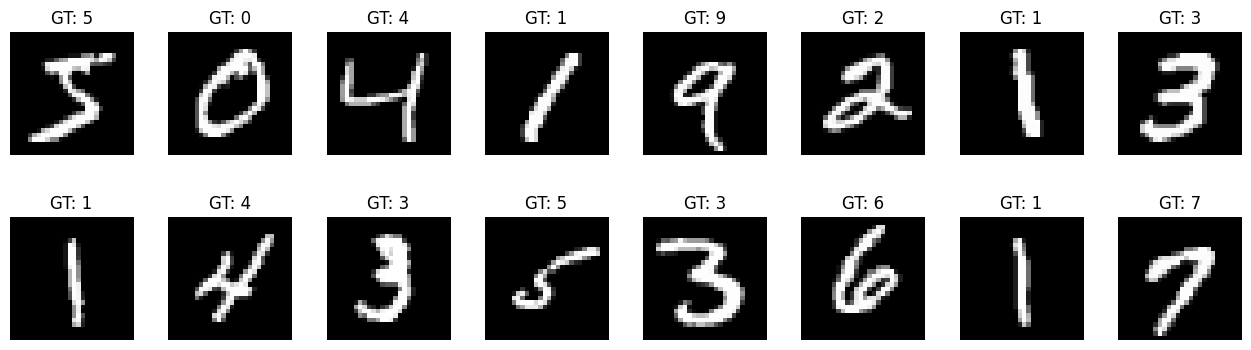

In [ ]:
display_mnist_images(train_X[:16], train_y[:16])

Prepare ground truth data in one-hot encoded format

In [ ]:
train_y_onehot = one_hot_encode(train_y)
train_y[:3], train_y_onehot[:3]

# NETWORK
Define the hyperparameters

In [ ]:
# number of neurons in each layer
# note: first one is the input layer which should match the dimension of the input data, the last one is the output layer that should match the number of classes
sizes = [784, 128, 32, 10]
# size of batches used for training the network
batch_size = 20
# number of training epochs
epochs = 10
# learning rate constant
eta = 1e-1

([(784, 128), (128, 32), (32, 10)], [(128,), (32,), (10,)])

Initialize the weights and biases

In [ ]:
num_layers = len(sizes)
weights = [np.random.randn(sizes[i], sizes[i+1]) for i in range(num_layers-1)]
biases = [np.random.randn(sizes[i+1]) for i in range(num_layers-1)]
[a.shape for a in weights], [a.shape for a in biases]

Define activation and loss functions and their derivatives

In [ ]:
def activation_fcn(z):
    """The sigmoid function."""
    return 1.0 / (1.0 + np.exp(-z))

def activation_fcn_derivative(z):
    """Derivative of the sigmoid function."""
    return activation_fcn(z) * (1 - activation_fcn(z))

def loss_fcn(a, y):
  """The cross entropy loss function."""
  return np.mean(np.nan_to_num(-y * np.log(a) - (1 - y) * np.log(1 - a)))

def loss_fcn_derivative(a, y):
  """Derivative of the cross entropy loss function."""
  return (a - y)

Write training protocol

In [ ]:
def train_step(x, y):
  global weights
  global biases

  # flatten from (batch_size, 28, 28) -> (batch_size, 784)
  activation = x.reshape(x.shape[0], -1)
  # initialize list of layer scores (weighted inputs) 'z'
  z_s = []
  # initialize list of layer activations 'a'
  a_s = [activation]

  # forward pass
  for enum, (w, b) in enumerate(zip(weights, biases)):
    z = activation @ w + b
    activation = activation_fcn(z)
    z_s.append(z)
    a_s.append(activation)

  ## calculate derivatives
  # initializations
  nabla_w = [None]*(num_layers-1)
  nabla_b = [None]*(num_layers-1)

  # calculate derivative to output layer
  loss = loss_fcn(a_s[-1], y)
  delta = loss_fcn_derivative(a_s[-1], y) * activation_fcn_derivative(z_s[-1])
  nabla_w[-1] = a_s[-2].T @ delta # use penultimate activation
  nabla_b[-1] = delta.sum(axis=0)

  # calculate derivative to hidden layers
  for l in range(2, num_layers):
    delta =  delta @ weights[-l+1].T * activation_fcn_derivative(z_s[-l])
    nabla_w[-l] = a_s[-l-1].T @ delta
    nabla_b[-l] = delta.sum(axis=0)
  return loss, nabla_w, nabla_b


def train_epoch(train_data, train_gt):
  global weights
  global biases
  N = train_data.shape[0]
  batches_data = [train_data[i:i + batch_size] for i in range(0, N, batch_size)]
  batches_gt = [train_gt[i:i + batch_size] for i in range(0, N, batch_size)]
  losses = []

  for batch_x, batch_y in zip(batches_data, batches_gt):
    # perform training step: calculate gradients
    loss, nabla_w, nabla_b = train_step(batch_x, batch_y)
    losses.append(loss)

    # update weights and biases with the calculated gradients
    weights = [w - (eta / batch_size) * nw for w, nw in zip(weights, nabla_w)]
    biases = [b - (eta / batch_size) * nb for b, nb in zip(biases, nabla_b)]
  return np.mean(losses)

Write inference protocol

In [ ]:
def inference(test_data):
  # flatten from (batch_size, 28, 28) -> (batch_size, 784)
  activation = test_data.reshape(test_data.shape[0], -1)

  # forward pass
  for enum, (w, b) in enumerate(zip(weights, biases)):
    z = activation @ w + b
    activation = activation_fcn(z)

  # get prediction from the final activation
  predictions = np.argmax(activation, axis=1)
  return predictions

def accuracy(preds, gts):
  return 100 * sum([int(x == y) for x, y in zip(preds, gts)]) / len(gts)

# EXPERIMENTS
Run training

In [ ]:
epoch_losses = []
for epoch in range(epochs):
  l = train_epoch(train_X, train_y_onehot)
  epoch_losses.append(l)

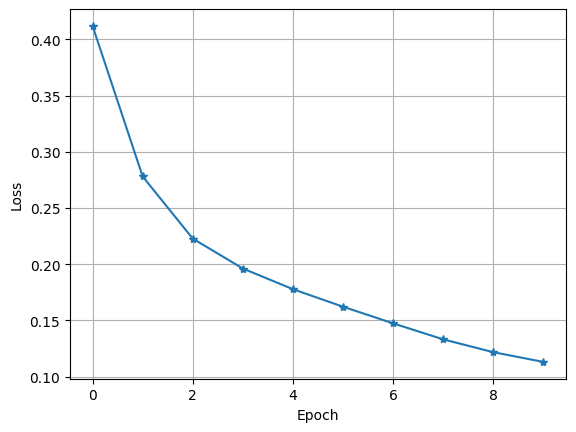

In [ ]:
plt.figure()
plt.plot(epoch_losses, marker='*')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()

Run inference

In [ ]:
test_pred = inference(test_X)
test_pred.shape, test_y.shape

((10000,), (10000,))

Calculate accuracy

In [ ]:
test_acc = accuracy(test_pred, test_y)
print(f'Test set accuracy: {test_acc:.2f} %')

Test set accuracy: 81.39 %


Visualize results

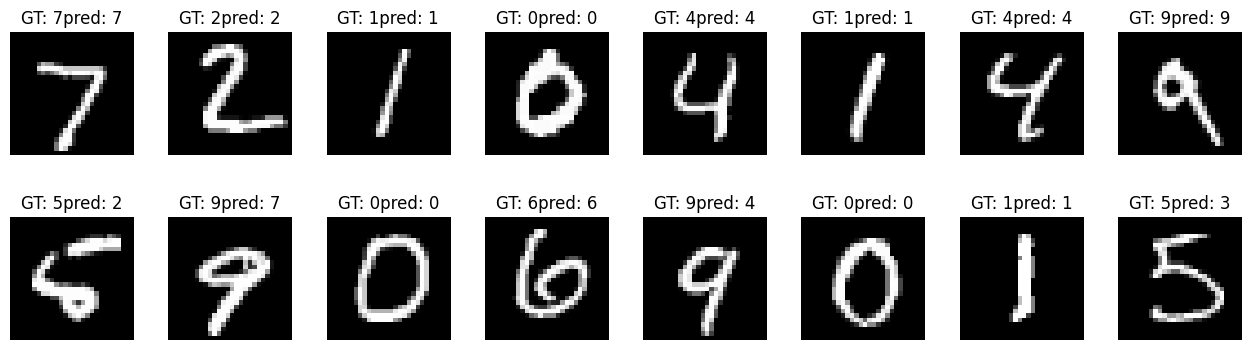

In [ ]:
display_mnist_images(test_X[:16], test_y[:16], test_pred[:16])